In [15]:
import requests
import pandas as pd
import seaborn as sns
import os
import datetime

In [16]:
def loadStooqData(ticker: str):
    url = f'https://stooq.pl/q/d/l/?s={ticker}&i=m'
    response = requests.get(url)
    dir_path = 'data'
    os.makedirs(dir_path, exist_ok=True)
    file_name = os.path.join(dir_path, f'{ticker}.{datetime.datetime.now().strftime("%Y.%m.%d.%H.%M")}.csv') 
    open(file_name,'wb').write(response.content)

    return pd.read_csv(file_name)

cpipl = loadStooqData('cpiypl.m')

cpipl = cpipl.set_index('Data')

cpipl = cpipl['Zamkniecie']

cpipl.tail(15)


Data
2022-02-28     8.5
2022-03-31    11.0
2022-04-30    12.4
2022-05-31    13.9
2022-06-30    15.5
2022-07-31    15.6
2022-08-31    16.1
2022-09-30    17.2
2022-10-31    17.9
2022-11-30    17.5
2022-12-31    16.6
2023-01-31    16.6
2023-02-28    18.4
2023-03-31    16.1
2023-04-30    14.7
Name: Zamkniecie, dtype: float64

In [17]:
cpius = loadStooqData('cpiyus.m')

cpius = cpius.set_index('Data')

cpius = cpius['Zamkniecie']

cpius.tail(15)

Data
2022-01-31    7.5
2022-02-28    7.9
2022-03-31    8.5
2022-04-30    8.3
2022-05-31    8.6
2022-06-30    9.1
2022-07-31    8.5
2022-08-31    8.3
2022-09-30    8.2
2022-10-31    7.7
2022-11-30    7.1
2022-12-31    6.5
2023-01-31    6.4
2023-02-28    6.0
2023-04-30    4.9
Name: Zamkniecie, dtype: float64

In [18]:
cpi = pd.merge(cpipl,cpius,right_index=True, left_index=True)
cpi.columns = ['CPIPL', 'CPIUS']
cpi = cpi['2003-12-31':]

In [19]:
cpi.tail(15)

,CPIPL,CPIUS
Data,,
2022-01-31,9.4,7.5
2022-02-28,8.5,7.9
2022-03-31,11.0,8.5
2022-04-30,12.4,8.3
2022-05-31,13.9,8.6
2022-06-30,15.5,9.1
2022-07-31,15.6,8.5
2022-08-31,16.1,8.3
2022-09-30,17.2,8.2


<AxesSubplot:xlabel='Data'>

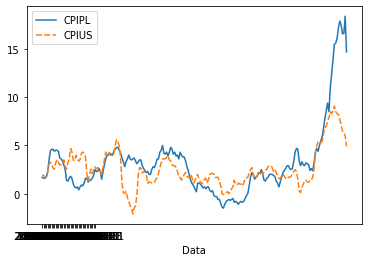

In [20]:
chart = sns.lineplot(data=cpi)
chart.set_xticks(range(40))
chart


<AxesSubplot:xlabel='Data'>

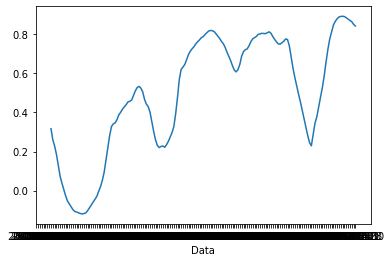

In [21]:
corr = cpi['CPIPL'].rolling(60).corr(cpi['CPIUS'])
sns.lineplot(data=corr)



In [22]:
cpi.corr('pearson')

,CPIPL,CPIUS
CPIPL,1.000000,0.735049
CPIUS,0.735049,1.000000


In [23]:
cpi.describe()

,CPIPL,CPIUS
count,226.000000,226.000000
mean,3.161947,2.572832
std,3.633433,1.967391
min,-1.500000,-2.100000
25%,1.300000,1.500000
50%,2.500000,2.100000
75%,4.000000,3.415000
max,18.400000,9.100000


In [24]:
cpipl.set_index('Data',inplace=True)
cpipl = cpipl['2002-01-31':'2023-03-31']

AttributeError: 'Series' object has no attribute 'set_index'

<AxesSubplot:xlabel='Data', ylabel='Zamkniecie'>

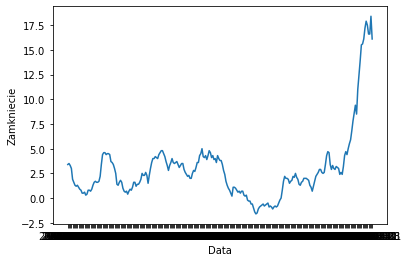

In [ ]:
sns.lineplot(data=cpipl['Zamkniecie'])

In [26]:
spx = loadStooqData('^SPX')
spx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2806 entries, 0 to 2805
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Data        2806 non-null   object 
 1   Otwarcie    2806 non-null   float64
 2   Najwyzszy   2806 non-null   float64
 3   Najnizszy   2806 non-null   float64
 4   Zamkniecie  2806 non-null   float64
 5   Wolumen     882 non-null    float64
dtypes: float64(5), object(1)
memory usage: 131.7+ KB


<AxesSubplot:ylabel='Zamkniecie'>

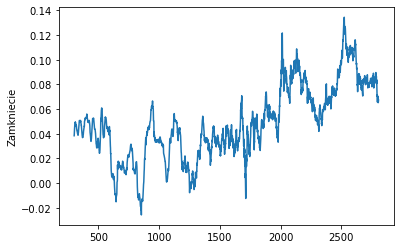

In [27]:
df = spx.set_index('Data')
df = spx['Zamkniecie'].pct_change()
means = df.rolling(300).mean() * 12
sns.lineplot(data=means)

In [28]:
usdpln = loadStooqData('usdpln')
usdpln = usdpln.set_index('Data')
usdpln = usdpln['Zamkniecie'].pct_change()

In [32]:
spx = spx.loc['2004-01-01':]



In [33]:
spx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 2005 to 2805
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Data        801 non-null    object 
 1   Otwarcie    801 non-null    float64
 2   Najwyzszy   801 non-null    float64
 3   Najnizszy   801 non-null    float64
 4   Zamkniecie  801 non-null    float64
 5   Wolumen     801 non-null    float64
dtypes: float64(5), object(1)
memory usage: 37.7+ KB


In [30]:
df.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,0
0,1789-05-31,0.51,0.51,0.51,0.51,NaN,NaN
1,1789-06-30,0.51,0.51,0.51,0.51,NaN,NaN
2,1789-07-31,0.50,0.50,0.50,0.50,NaN,NaN
3,1789-08-31,0.50,0.51,0.50,0.51,NaN,NaN
4,1789-09-30,0.51,0.51,0.50,0.51,NaN,NaN
